In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc

# !apt install imagemagick # gif作成に必要


In [53]:
BATCH_SIZE = 100

trainval_data = MNIST("./data", 
                   train=True, 
                   download=True, 
                   transform=transforms.ToTensor())

train_size = int(len(trainval_data) * 0.8)
val_size = int(len(trainval_data) * 0.2)
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=0)

print("train data size: ",len(train_data))   #train data size:  48000
print("train iteration number: ",len(train_data)//BATCH_SIZE)   #train iteration number:  480
print("val data size: ",len(val_data))   #val data size:  12000
print("val iteration number: ",len(val_data)//BATCH_SIZE)   #val iteration number:  120


train data size:  48000
train iteration number:  480
val data size:  12000
val iteration number:  120


images_size: torch.Size([100, 1, 28, 28])
label: tensor([7, 1, 5, 8, 2, 6, 1, 9, 9, 6])


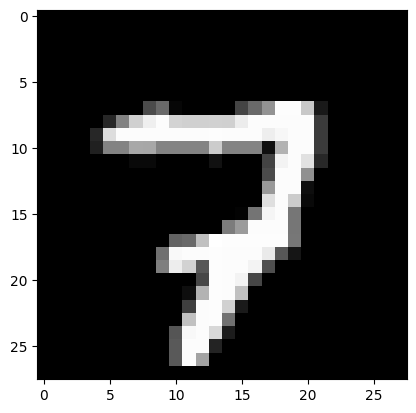

In [54]:
images, labels = next(iter(train_loader))
print("images_size:",images.size())   #images_size: torch.Size([100, 1, 28, 28])
print("label:",labels[:10])   #label: tensor([7, 6, 0, 6, 4, 8, 5, 2, 2, 3])

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')


In [55]:
class Encoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(28*28, 300)
    self.lr2 = nn.Linear(300, 100)
    self.lr_ave = nn.Linear(100, z_dim)   #average
    self.lr_dev = nn.Linear(100, z_dim)   #log(sigma^2)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    x = self.lr(x)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    ave = self.lr_ave(x)    #average
    log_dev = self.lr_dev(x)    #log(sigma^2)

    ep = torch.randn_like(ave)   #平均0分散1の正規分布に従い生成されるz_dim次元の乱数
    z = ave + torch.exp(log_dev / 2) * ep   #再パラメータ化トリック
    return z, ave, log_dev

class Decoder(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.lr = nn.Linear(z_dim, 100)
    self.lr2 = nn.Linear(100, 300)
    self.lr3 = nn.Linear(300, 28*28)
    self.relu = nn.ReLU()
  
  def forward(self, z):
    x = self.lr(z)
    x = self.relu(x)
    x = self.lr2(x)
    x = self.relu(x)
    x = self.lr3(x)
    x = torch.sigmoid(x)   #MNISTのピクセル値の分布はベルヌーイ分布に近いと考えられるので、シグモイド関数を適用します。
    return x

class VAE(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.encoder = Encoder(z_dim)
    self.decoder = Decoder(z_dim)
  
  def forward(self, x):
    z, ave, log_dev = self.encoder(x)
    x = self.decoder(z)
    return x, z, ave, log_dev


In [56]:
def criterion(predict, target, ave, log_dev):
  bce_loss = F.binary_cross_entropy(predict, target, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + log_dev - ave**2 - log_dev.exp())
  loss = bce_loss + kl_loss
  return loss


In [58]:
z_dim = 2
num_epochs = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1)

history = {"train_loss": [], "val_loss": [], "ave": [], "log_dev": [], "z": [], "labels":[]}

for epoch in range(num_epochs):
  model.train()
  for i, (x, labels) in enumerate(train_loader):
    input = x.to(device).view(-1, 28*28).to(torch.float32)
    output, z, ave, log_dev = model(input)

    history["ave"].append(ave)
    history["log_dev"].append(log_dev)
    history["z"].append(z)
    history["labels"].append(labels)
    loss = criterion(output, input, ave, log_dev)
     
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
     
    if (i+1) % 50 == 0:
      print(f'Epoch: {epoch+1}, loss: {loss: 0.4f}')
    history["train_loss"].append(loss)

  model.eval()
  with torch.no_grad():
    for i, (x, labels) in enumerate(val_loader):
      input = x.to(device).view(-1, 28*28).to(torch.float32)
      output, z, ave, log_dev = model(input)

      loss = criterion(output, input, ave, log_dev)
      history["val_loss"].append(loss)
      
    print(f'Epoch: {epoch+1}, val_loss: {loss: 0.4f}')
  
  scheduler.step()


Epoch: 45, loss:  14301.9541
Epoch: 45, loss:  13036.2012
Epoch: 45, loss:  13638.7578
Epoch: 45, loss:  14056.5479
Epoch: 45, loss:  13431.2539
Epoch: 45, loss:  14562.0205
Epoch: 45, loss:  13339.0059
Epoch: 45, loss:  13919.3271
Epoch: 45, val_loss:  13359.9619
Epoch: 46, loss:  13655.0859
Epoch: 46, loss:  14062.4512
Epoch: 46, loss:  15017.2510
Epoch: 46, loss:  13574.5508
Epoch: 46, loss:  14148.2402
Epoch: 46, loss:  13987.1738
Epoch: 46, loss:  13988.9863
Epoch: 46, loss:  13365.1846
Epoch: 46, loss:  13457.3877
Epoch: 46, val_loss:  14479.4473
Epoch: 47, loss:  14311.8262
Epoch: 47, loss:  13779.5498
Epoch: 47, loss:  13650.5352
Epoch: 47, loss:  13423.7871
Epoch: 47, loss:  14897.6885
Epoch: 47, loss:  13763.3691
Epoch: 47, loss:  13105.0371
Epoch: 47, loss:  14793.0186
Epoch: 47, loss:  13970.1855
Epoch: 47, val_loss:  14559.6064
Epoch: 48, loss:  13294.0391
Epoch: 48, loss:  14576.7500
Epoch: 48, loss:  13450.2568
Epoch: 48, loss:  14017.8564
Epoch: 48, loss:  13968.3301
Ep

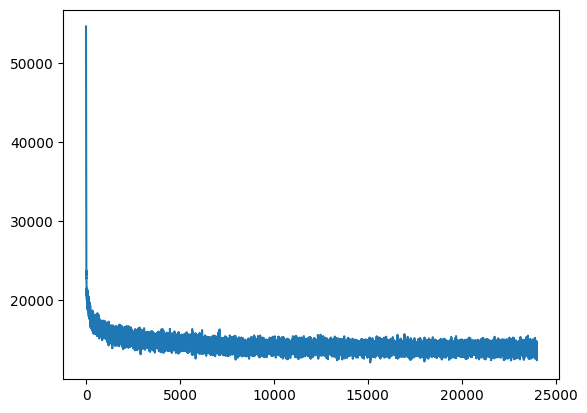

In [59]:
train_loss_tensor = torch.stack(history["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)


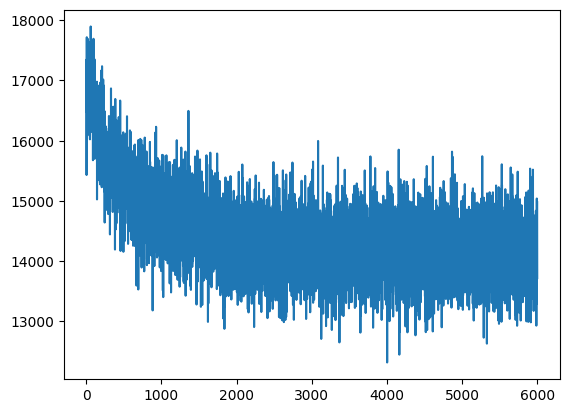

In [60]:
val_loss_tensor = torch.stack(history["val_loss"])
val_loss_np = val_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(val_loss_np)


In [61]:
ave_tensor = torch.stack(history["ave"])
log_var_tensor = torch.stack(history["log_dev"])
z_tensor = torch.stack(history["z"])
labels_tensor = torch.stack(history["labels"])
print(ave_tensor.size())   #torch.Size([9600, 100, 2])
print(log_var_tensor.size())   #torch.Size([9600, 100, 2])
print(z_tensor.size())   #torch.Size([9600, 100, 2])
print(labels_tensor.size())   #torch.Size([9600, 100])

ave_np = ave_tensor.to('cpu').detach().numpy().copy()
log_var_np = log_var_tensor.to('cpu').detach().numpy().copy()
z_np = z_tensor.to('cpu').detach().numpy().copy()
labels_np = labels_tensor.to('cpu').detach().numpy().copy()
print(ave_np.shape)   #(9600, 100, 2)
print(log_var_np.shape)   #(9600, 100, 2)
print(z_np.shape)   #(9600, 100, 2)
print(labels_np.shape)   #(9600, 100)


torch.Size([24000, 100, 2])
torch.Size([24000, 100, 2])
torch.Size([24000, 100, 2])
torch.Size([24000, 100])
(24000, 100, 2)
(24000, 100, 2)
(24000, 100, 2)
(24000, 100)


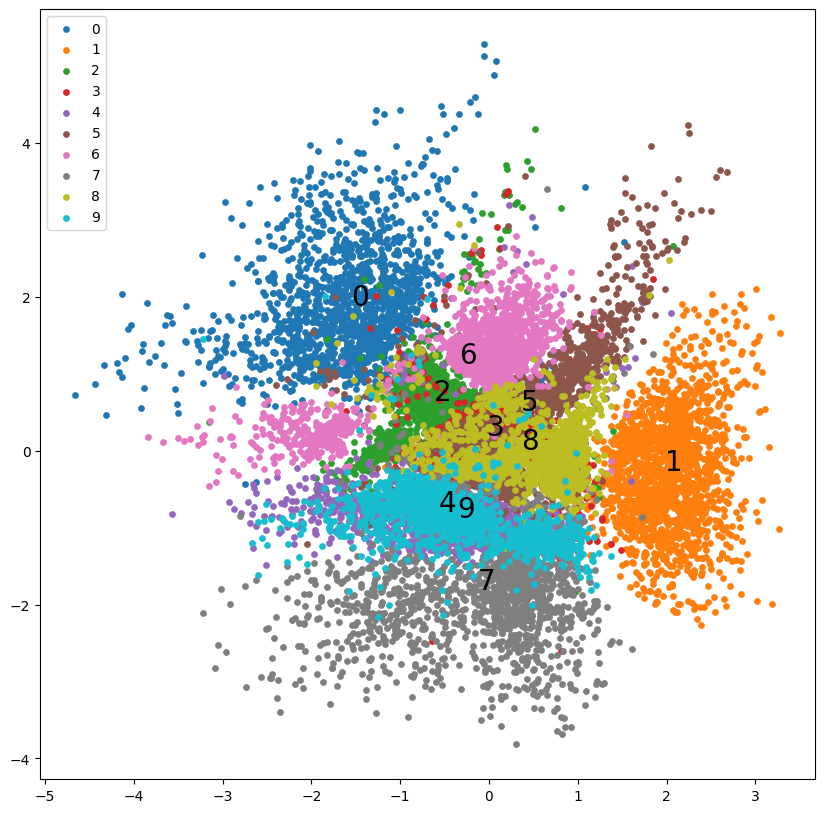

In [63]:
batch_num = 23850
plt.figure(figsize=[10,10])
for label in range(10):
  x = z_np[batch_num:,:,0][labels_np[batch_num:,:] == label]
  y = z_np[batch_num:,:,1][labels_np[batch_num:,:] == label]
  plt.scatter(x, y, color=cmap(label/9), label=label, s=15)
  plt.annotate(label, xy=(np.mean(x),np.mean(y)),size=20,color="black")
plt.legend(loc="upper left")


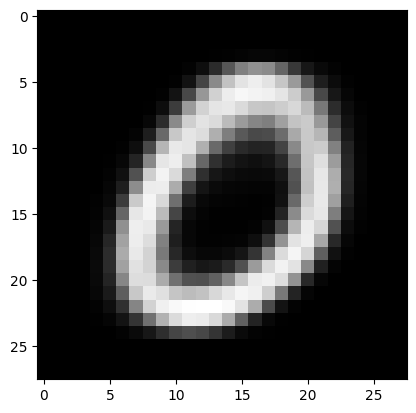

In [64]:
model.to("cpu")

label = 0
x_zero_mean = np.mean(ave_np[batch_num:,:,0][labels_np[batch_num:,:] == label])   #x軸の平均値
y_zero_mean = np.mean(ave_np[batch_num:,:,1][labels_np[batch_num:,:] == label])   #y軸の平均値
z_zero = torch.tensor([x_zero_mean,y_zero_mean], dtype = torch.float32)

output = model.decoder(z_zero)
np_output = output.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_output, (28, 28))
plt.imshow(np_image, cmap='gray')


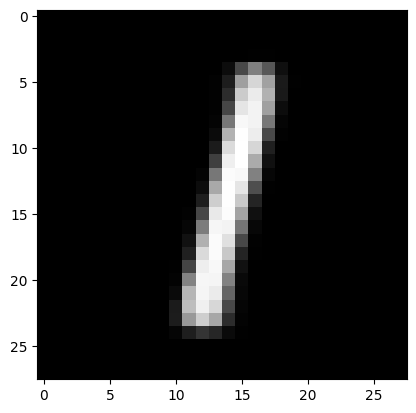

In [65]:
label = 1
x_one_mean = np.mean(ave_np[batch_num:,:,0][labels_np[batch_num:,:] == label])   #x軸の平均値
y_one_mean = np.mean(ave_np[batch_num:,:,1][labels_np[batch_num:,:] == label])   #y軸の平均値
z_one = torch.tensor([x_one_mean,y_one_mean], dtype = torch.float32)

output = model.decoder(z_one)
np_output = output.to('cpu').detach().numpy().copy()
np_image = np.reshape(np_output, (28, 28))
plt.imshow(np_image, cmap='gray')


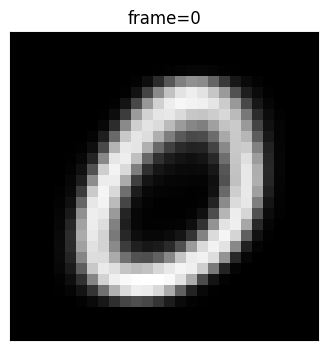

In [66]:
def plot(frame):
    plt.cla()
    z_zerotoone = ((99 - frame) * z_zero +  frame * z_one) / 99
    output = model.decoder(z_zerotoone)
    np_output = output.detach().numpy().copy()
    np_image = np.reshape(np_output, (28, 28))
    plt.imshow(np_image, cmap='gray')
    plt.xticks([]);plt.yticks([])
    plt.title("frame={}".format(frame))

fig = plt.figure(figsize=(4,4))
ani = animation.FuncAnimation(fig, plot, frames=99, interval=100)
rc('animation', html='jshtml')
ani


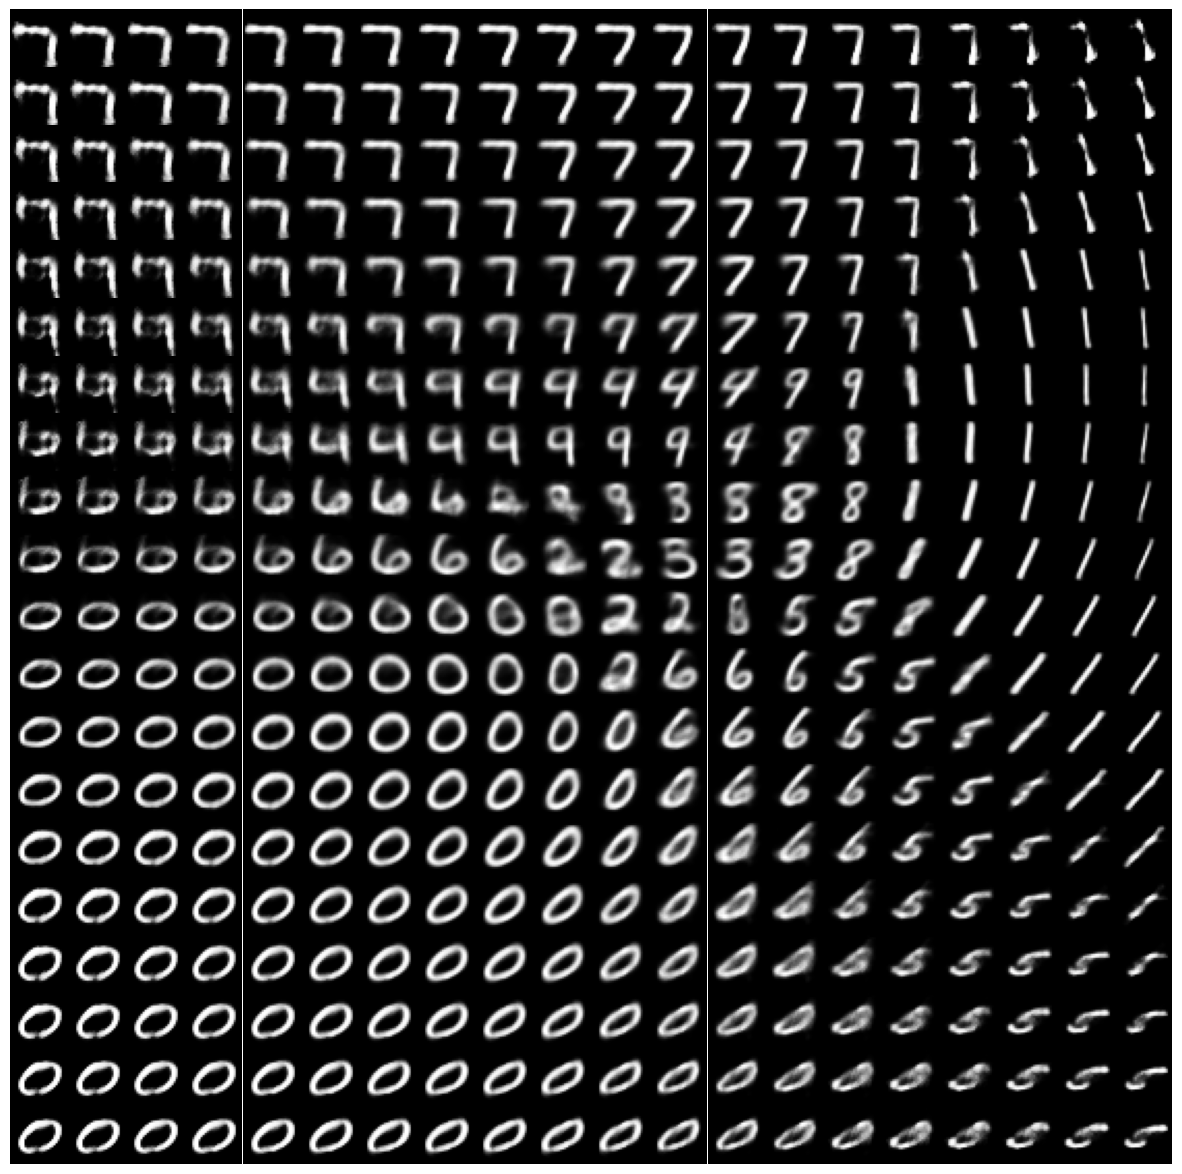

In [74]:
# 潜在空間の範囲を設定
sample_range_x = np.linspace(-5, 3, 20)
sample_range_y = np.linspace(-4, 5, 20)

# プロットの準備
fig, axes = plt.subplots(len(sample_range_x), len(sample_range_y), figsize=(15, 15))
axes = axes.reshape(len(sample_range_x), len(sample_range_y))  # 必要に応じてリシェイプ

# 各潜在変数に対応する画像を描画
for i, x in enumerate(sample_range_x):
    for j, y in enumerate(sample_range_y):
        z_sample = torch.tensor([x, y], dtype=torch.float32)
        output = model.decoder(z_sample)
        np_output = output.detach().numpy().copy()
        np_image = np.reshape(np_output, (28, 28))
        axes[j, i].imshow(np_image, cmap='gray')  # 軸を反転する場合
        axes[j, i].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

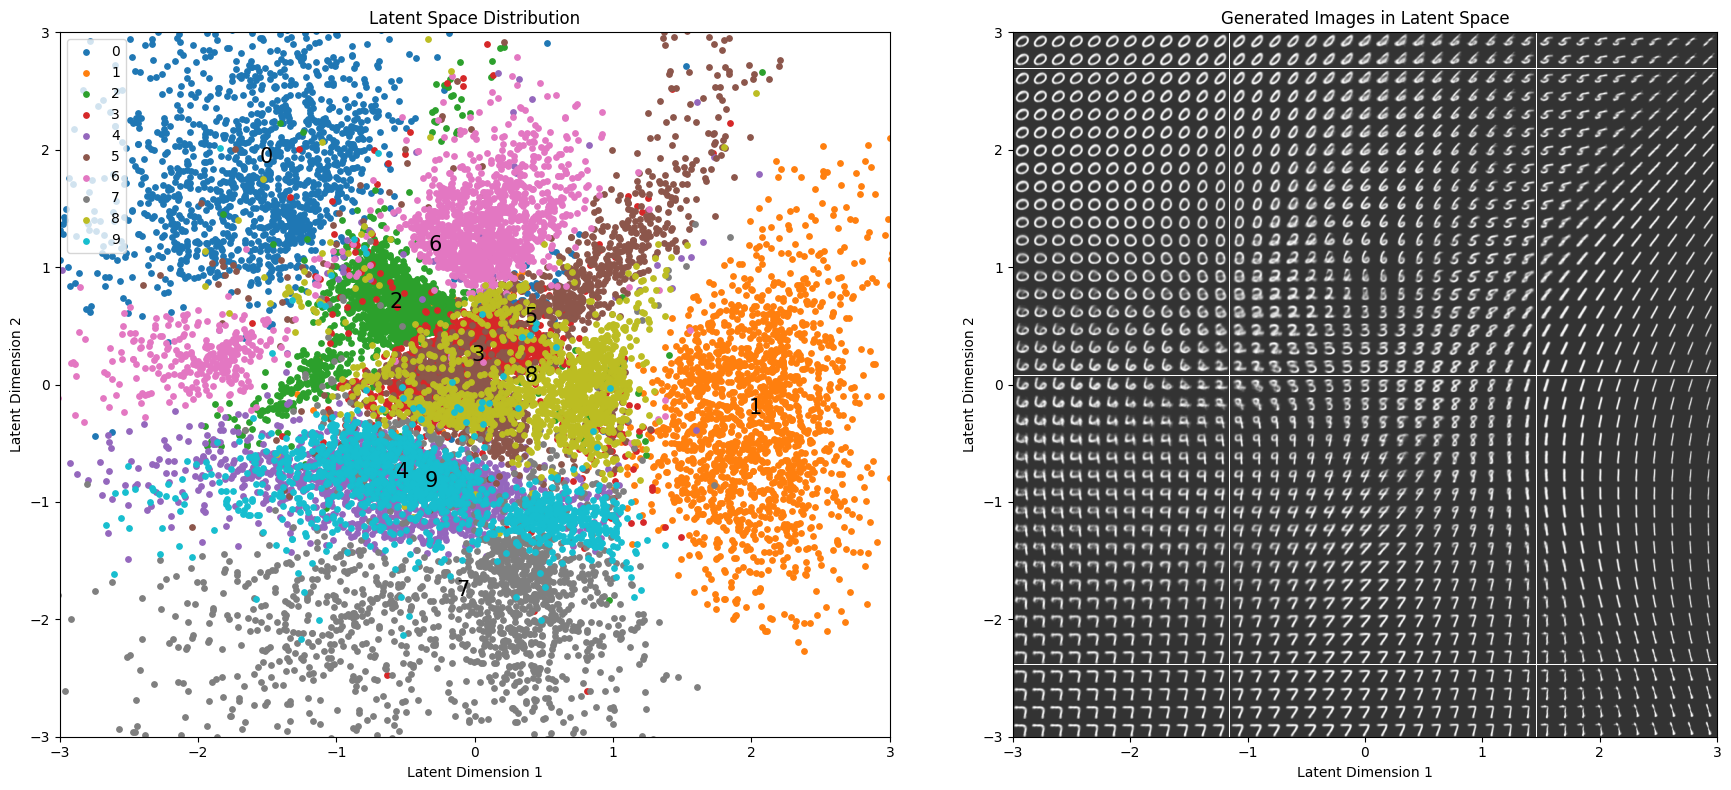

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# サンプルデータ: 潜在変数 z とラベル（z_np と labels_np は事前に定義されている必要があります）
batch_num = 23850

# 潜在空間の範囲を固定
fixed_min, fixed_max = -3, 3  # 第一軸と第二軸の範囲
sample_range_x = np.linspace(fixed_min, fixed_max, 10)  # x軸方向: -3 から 3
sample_range_y = np.linspace(fixed_min, fixed_max, 10)  # y軸方向: -3 から 3

# 図の準備
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 横並びで配置

# --- 1. 潜在空間の分布をプロット ---
scatter_ax = axes[0]
for label in range(10):
    x = z_np[batch_num:, :, 0][labels_np[batch_num:, :] == label]
    y = z_np[batch_num:, :, 1][labels_np[batch_num:, :] == label]
    scatter_ax.scatter(x, y, color=plt.cm.tab10(label / 9), label=label, s=15)
    scatter_ax.annotate(label, xy=(np.mean(x), np.mean(y)), size=15, color="black")

scatter_ax.set_xlim(fixed_min, fixed_max)  # x軸の範囲を固定
scatter_ax.set_ylim(fixed_min, fixed_max)  # y軸の範囲を固定
scatter_ax.set_xlabel("Latent Dimension 1")
scatter_ax.set_ylabel("Latent Dimension 2")
scatter_ax.set_title("Latent Space Distribution")
scatter_ax.legend(loc="upper left")

# --- 2. 潜在空間の各点で生成される画像を可視化 ---
image_ax = axes[1]

# 生成画像の数を4倍に増やす（範囲を細かく分割）
num_points = 40  # 点の数を増やす
sample_range_x = np.linspace(fixed_min, fixed_max, num_points)  # x軸方向
sample_range_y = np.linspace(fixed_min, fixed_max, num_points)  # y軸方向

# 各点で生成された画像をプロット
image_size = (fixed_max - fixed_min) / num_points  # 各画像の幅と高さを計算
for i, x in enumerate(sample_range_x):
    for j, y in enumerate(sample_range_y):
        z_sample = torch.tensor([x, y], dtype=torch.float32)
        output = model.decoder(z_sample)  # VAEデコーダを使用して画像生成
        np_output = output.detach().numpy().copy()
        np_image = np.reshape(np_output, (28, 28))

        # 画像を潜在空間の対応する座標に直接プロット（余白なし）
        image_ax.imshow(
            np_image, 
            extent=(x, x + image_size, y, y + image_size), 
            cmap="gray", 
            alpha=0.8
        )

# 軸範囲を固定
image_ax.set_xlim(fixed_min, fixed_max)  # x軸の範囲を固定
image_ax.set_ylim(fixed_min, fixed_max)  # y軸の範囲を固定
image_ax.set_xlabel("Latent Dimension 1")
image_ax.set_ylabel("Latent Dimension 2")
image_ax.set_title("Generated Images in Latent Space")


# 図を表示
plt.tight_layout()
plt.show()
